## LSTM + CNN for stock prediction

### Setting model parameter

In [1]:
import pandas as pd
from datetime import datetime
EPOCHS = 100
BATCH_SIZE = 32
TIME_STEPS = 32
OPTIMIZER = "adam"
LOSS = "mse"
MEAN = 10
PTC = True
STOCK_TICKER = 'IBM'  # Ticker of company
# Train data from start date to validation date
STOCK_START_DATE = pd.to_datetime('2005-01-01')
STOCK_END_DATE = pd.to_datetime('2022-01-04')
STOCK_VALIDATION_PER = 0.2
CHECKPOINT_FOLDER = "./checkpoint/lstm-cnn"


### Read data and split data to train and test

In [2]:
import yfinance as yf
print("Train Data From: " + STOCK_START_DATE.strftime("%Y-%m-%d"), end=" ")
print('To: ' + STOCK_END_DATE.strftime("%Y-%m-%d"))
df = yf.download([STOCK_TICKER], start=STOCK_START_DATE, end=STOCK_END_DATE)
df.head()

Train Data From: 2005-01-01 To: 2022-01-04
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-12-31,94.263863,94.560226,94.158699,94.244743,58.302254,2921687
2005-01-03,94.617592,94.741875,92.973228,93.451241,57.811337,5538779
2005-01-04,93.441681,94.091782,92.275337,92.447418,57.190342,5973706
2005-01-05,92.351814,93.527725,92.160614,92.256210,57.072105,5906448
2005-01-06,92.294456,92.715103,91.826004,91.969406,56.894672,4771538


### Moving Average closing price

<AxesSubplot:title={'center':'Mean Close Price'}, xlabel='Date'>

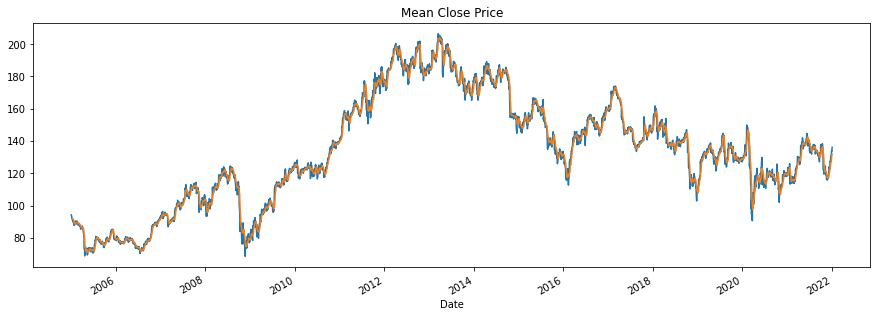

In [3]:
import matplotlib.pyplot as plt
df_mean = df.copy()
if MEAN > 1:
# Apply moving average with a window of MEAN days to all columns
    df_mean[['Close']] = df[['Close']].rolling(MEAN).mean() 
    # Drop all rows with NaN values
    df_mean.dropna(how='any', axis=0, inplace=True)
plt.figure(figsize=(15, 5))
df['Close'].plot(title="Close Price")
df_mean['Close'].plot(title="Mean Close Price")

### Calculate percentage change for all columns

In [4]:
if PTC:
    df_mean['Close'] = df_mean['Close'].pct_change()
    df_mean.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values

### Data distribution

<AxesSubplot:xlabel='Close', ylabel='Count'>

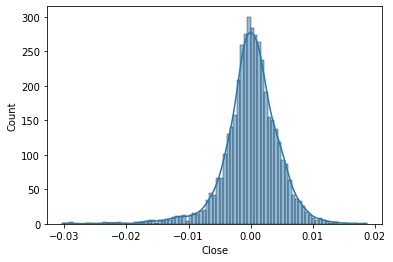

In [5]:
import seaborn as sns
sns.histplot(df_mean['Close'], kde=True)

### Split data

In [6]:
times = sorted(df_mean.index.values)
greater_train_index = times[-int(STOCK_VALIDATION_PER*len(times))]
df_train = df_mean[df_mean.index < greater_train_index].copy()
df_val = df_mean[df_mean.index >= greater_train_index].copy()

print('Training data shape: {}'.format(df_train.shape))
print('Validation data shape: {}'.format(df_val.shape))

Training data shape: (3418, 6)
Validation data shape: (854, 6)


### Plot daily changes of close prices and volume

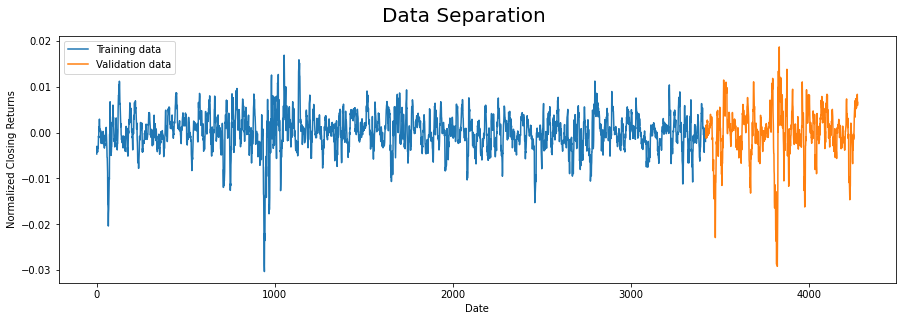

In [7]:
import numpy as np
fig = plt.figure(figsize=(15,10))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(0.92)

###############################################################################

ax1 = fig.add_subplot(211)
ax1.plot(np.arange(df_train.shape[0]), df_train['Close'], label='Training data')

ax1.plot(np.arange(df_train.shape[0], 
                   df_train.shape[0]+df_val.shape[0]), df_val['Close'], label='Validation data')

ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized Closing Returns')


plt.legend(loc='best')

### Normalization

In [8]:
from sklearn.preprocessing import MinMaxScaler
'''Normalize price columns'''
min_max = MinMaxScaler()
min_max.fit(df_mean[['Close']])
train_scaled = min_max.transform(df_train[['Close']])
val_scaled = min_max.transform(df_val[['Close']])

### Create data label by time sequence

In [9]:
import data
# Serialize data and generate labels for train data
x_train, y_train = data.create_data_label(train_scaled, TIME_STEPS)
x_validation, y_validation = data.create_data_label(val_scaled, TIME_STEPS)
print('Shape Of X_Train Data :')
print(x_train.shape)
print('Shape of X_Validation Data :')
print(x_validation.shape)

Shape Of X_Train Data :
(3386, 32, 1)
Shape of X_Validation Data :
(822, 32, 1)


### LSTM + CNN Model

In [10]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.utils import plot_model
model = Sequential()
in_seq = InputLayer(input_shape = (x_train.shape[1], 1))
model.add(in_seq)
model.add(Conv1D(32, kernel_size=1, activation="relu", strides=1, padding="same"))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Conv1D(32, kernel_size=3, activation="relu", strides=2, padding="same"))
model.add(BatchNormalization())
model.add(ReLU())
model.add(LSTM(units=128, return_sequences=True))
model.add(Dropout(0.25))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.25))
model.add(LSTM(units=64))
model.add(Dropout(0.25))
model.add(Dense(units=1))
model.summary()
plot_model(model, to_file='./img/model_lstm_cnn.png', show_shapes=True,
                              show_layer_names=True)
model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=[
    'mae'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 32, 32)            64        
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32)            128       
_________________________________________________________________
re_lu (ReLU)                 (None, 32, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16, 32)            3104      
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 32)            128       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 16, 32)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 16, 128)           8

### Train model

In [62]:
import tensorflow as tf
history = model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(x_validation, y_validation),
                       callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=1)])
model.save(CHECKPOINT_FOLDER)
#Print evaluation metrics for all datasets
train_eval = model.evaluate(x_train, y_train, verbose=0)
val_eval = model.evaluate(x_validation, y_validation, verbose=0)
print('Training Data - Loss: {:.4f}, MAE: {:.4f}'.format(train_eval[0], train_eval[1]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}'.format(val_eval[0], val_eval[1]))

Epoch 1/100
106/106 [==============================] - 15s 69ms/step - loss: 0.0250 - mae: 0.1084 - val_loss: 0.0497 - val_mae: 0.2044
Epoch 2/100
106/106 [==============================] - 8s 72ms/step - loss: 0.0077 - mae: 0.0675 - val_loss: 0.0392 - val_mae: 0.1790
Epoch 3/100
106/106 [==============================] - 8s 72ms/step - loss: 0.0062 - mae: 0.0611 - val_loss: 0.0309 - val_mae: 0.1567
Epoch 4/100
106/106 [==============================] - 8s 75ms/step - loss: 0.0054 - mae: 0.0574 - val_loss: 0.0149 - val_mae: 0.0983
Epoch 5/100
106/106 [==============================] - 8s 72ms/step - loss: 0.0049 - mae: 0.0542 - val_loss: 0.0101 - val_mae: 0.0768
Epoch 6/100
106/106 [==============================] - 7s 68ms/step - loss: 0.0044 - mae: 0.0519 - val_loss: 0.0067 - val_mae: 0.0562
Epoch 7/100
106/106 [==============================] - 8s 72ms/step - loss: 0.0039 - mae: 0.0489 - val_loss: 0.0049 - val_mae: 0.0511
Epoch 8/100
106/106 [==============================] - 7s 69m

INFO:tensorflow:Assets written to: ./checkpoint/lstm-cnn\assets


INFO:tensorflow:Assets written to: ./checkpoint/lstm-cnn\assets


Training Data - Loss: 0.0014, MAE: 0.0281
Validation Data - Loss: 0.0030, MAE: 0.0377


### Visualize loss by epochs

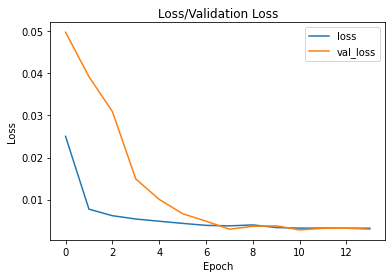

In [63]:
import visualize
visualize.visualize_loss(history)

### Set data to test

Test Data From: 2017-01-01 End Date: 2022-02-21
[*********************100%***********************]  1 of 1 completed


<AxesSubplot:title={'center':'Close Price'}, xlabel='Date'>

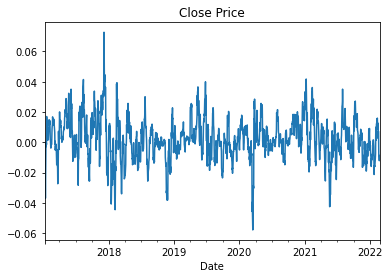

In [64]:
import pandas as pd
TEST_TICKER = 'BTC-USD'
STOCK_TEST_DATE = pd.to_datetime('2017-01-01') # Test data from this to now
import yfinance as yf
from datetime import datetime
print("Test Data From: " + STOCK_TEST_DATE.strftime("%Y-%m-%d"), end=" ")
end_date = datetime.today()
print('End Date: ' + end_date.strftime("%Y-%m-%d"))
test_data = yf.download([TEST_TICKER], start=STOCK_TEST_DATE, end=end_date)
if MEAN > 1:
    test_data[['Close']] = test_data[['Close']].rolling(MEAN).mean()
    test_data.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values
if PTC:
    test_data['Close'] = test_data['Close'].pct_change()
    test_data.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values
test_data['Close'].plot(title="Close Price")

In [65]:
from sklearn.preprocessing import MinMaxScaler
'''Normalize price columns'''
min_max_test = MinMaxScaler()
min_max_test.fit(test_data[['Close']])
test_scaled = min_max_test.transform(test_data[['Close']])

import data
# Serialize data and generate labels for train data
x_test, y_test = data.create_data_label(test_scaled, TIME_STEPS)
print('Shape Of X_Test Data :')
print(x_test.shape)

Shape Of X_Test Data :
(1837, 32, 1)


In [66]:
import visualize
import tensorflow as tf
model = tf.keras.models.load_model(CHECKPOINT_FOLDER)
test_predictions = model.predict(x_test)
print("predict shape")
print(test_predictions.shape)
# visualize.visualize_predict(y_test,
#     test_predictions, model_name="LSTM")
test_eval = model.evaluate(x_test, y_test, verbose=0)
print('Test Data - Loss: {:.4f}, MSE: {:.4f}'.format(test_eval[0], test_eval[1]))

predict shape
(1837, 1)
Test Data - Loss: 0.0030, MSE: 0.0432


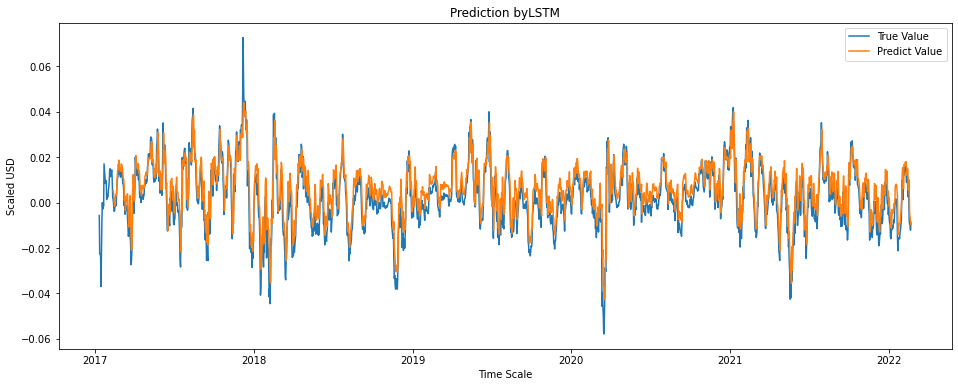

In [67]:
test_predictions = min_max_test.inverse_transform(test_predictions)
test_predictions = pd.DataFrame(test_predictions)
test_predictions.rename(
    columns={0: TEST_TICKER + '_predicted'}, inplace=True)
# test_predictions = test_predictions.round(decimals=0)
test_predictions.index = test_data[TIME_STEPS:].index
visualize.visualize_predict(test_data['Close'],
    test_predictions, model_name="LSTM")

In [68]:
print(test_predictions[:20])
print(test_data['Close'][32:52])

            BTC-USD_predicted
Date                         
2017-02-11           0.005271
2017-02-12           0.003943
2017-02-13           0.001081
2017-02-14          -0.001647
2017-02-15          -0.001073
2017-02-16           0.001832
2017-02-17           0.003507
2017-02-18           0.003154
2017-02-19           0.003846
2017-02-20           0.010426
2017-02-21           0.013547
2017-02-22           0.014482
2017-02-23           0.014562
2017-02-24           0.018672
2017-02-25           0.017746
2017-02-26           0.015252
2017-02-27           0.015056
2017-02-28           0.014476
2017-03-01           0.013627
2017-03-02           0.016994
Date
2017-02-11    0.001506
2017-02-12   -0.001230
2017-02-13   -0.003831
2017-02-14   -0.003756
2017-02-15   -0.001952
2017-02-16   -0.001055
2017-02-17   -0.001493
2017-02-18   -0.000854
2017-02-19    0.005287
2017-02-20    0.008977
2017-02-21    0.010802
2017-02-22    0.011401
2017-02-23    0.016783
2017-02-24    0.015855
2017-02-25   